In [42]:
import tensorflow as tf 
import tensorflow_io as tfio
import tensorflow_probability as tfp

print(tf.__version__)
print('Listing all GPU resources:')
print(tf.config.experimental.list_physical_devices('GPU'))
print()
import tensorflow.keras as keras
print(tfp.__version__)
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import pickle
import os

from tqdm import trange

2.2.0
Listing all GPU resources:
[]

0.9.0


In [71]:
BATCH_SIZE = 128
FILTERS = 32
EPOCHS = 200
VERBOSE = 2
DATA_PATH = '../data/Task01_BrainTumour.h5'
PICKLE_PATH = 'Layer_1_hist.pkl'

DATA_SIZE = 60000

PRIOR_MU = 0
PRIOR_SIGMA = 10
N_PREDICTIONS = 100

In [5]:
# ### Data

# Xy_train = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(np.load('../data/imgs_train.npy')),
#                                 tf.data.Dataset.from_tensor_slices(np.load('../data/msks_train.npy')))).cache().batch(BATCH_SIZE).prefetch(8)
# Xy_test = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(np.load('../data/imgs_test.npy')),
#                                 tf.data.Dataset.from_tensor_slices(np.load('../data/msks_test.npy')))).cache().batch(BATCH_SIZE).prefetch(8)


mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    
    class KLDivergence:
        def __init__(self, q_dist, p_dist):
            self.q_dist = q_dist         
            self.p_dist = p_dist
        def call(self):
            return tfp.distributions.kl_divergence(self.q_dist, self.p_dist)

    def mean_binary_crossentropy(y, y_pred):
        return tf.reduce_mean(keras.losses.binary_crossentropy(y, y_pred))

    def sum_binary_crossentropy(y, y_pred):
        return DATA_SIZE * mean_binary_crossentropy(y, y_pred)

    def likelihood_loss(y, y_pred):
        return sum_binary_crossentropy(y, y_pred)
    
    posterior_fn = tfp.layers.default_mean_field_normal_fn(
                  loc_initializer=tf.random_normal_initializer(
                      mean=PRIOR_MU, stddev=0.05),
                  untransformed_scale_initializer=tf.random_normal_initializer(
                      mean=np.log(np.exp(PRIOR_SIGMA) - 1), stddev=0.05))

    prior_fn = tfp.layers.default_mean_field_normal_fn(
                      loc_initializer=tf.random_normal_initializer(
                          mean=PRIOR_MU, stddev=0.0),
                      untransformed_scale_initializer=tf.random_normal_initializer(
                          mean=np.log(np.exp(PRIOR_SIGMA) - 1), stddev=0))

    flipout_params = dict(kernel_size=(3, 3), activation="relu", padding="same", 
                  kernel_prior_fn=prior_fn,
                  bias_prior_fn=prior_fn,
                  kernel_posterior_fn=posterior_fn,
                  bias_posterior_fn=posterior_fn,
                  kernel_divergence_fn=None,
                  bias_divergence_fn=None)

    params_final = dict(kernel_size=(1, 1), activation="sigmoid", padding="same", 
                      data_format="channels_last",
                  kernel_initializer="he_uniform")

    params = dict(kernel_size=(3, 3), activation="relu",
                  padding="same", data_format="channels_last",
                  kernel_initializer="he_uniform")
    

    input_layer = keras.layers.Input(shape=(144, 144, 4), name="input_layer")

    encoder_1_a = tfp.layers.Convolution2DFlipout(FILTERS, name='encoder_1_a', **flipout_params)(input_layer)
    encoder_1_b = keras.layers.Conv2D(FILTERS, name='encoder_1_b', **params)(encoder_1_a)
    downsample_1 = keras.layers.MaxPool2D(name='downsample_1')(encoder_1_b)

    encoder_2_a = keras.layers.Conv2D(FILTERS*2, name='encoder_2_a', **params)(downsample_1)
    encoder_2_b = keras.layers.Conv2D(FILTERS*2, name='encoder_2_b', **params)(encoder_2_a)
    downsample_2 = keras.layers.MaxPool2D(name='downsample_2')(encoder_2_b)

    encoder_3_a = keras.layers.Conv2D(FILTERS*4, name='encoder_3_a', **params)(downsample_2)
    encoder_3_b = keras.layers.Conv2D(FILTERS*4, name='encoder_3_b', **params)(encoder_3_a)
    downsample_3 = keras.layers.MaxPool2D(name='downsample_3')(encoder_3_b)

    encoder_4_a = keras.layers.Conv2D(FILTERS*8, name='encoder_4_a', **params)(downsample_3)
    encoder_4_b = keras.layers.Conv2D(FILTERS*8, name='encoder_4_b', **params)(encoder_4_a)
    downsample_4 = keras.layers.MaxPool2D(name='downsample_4')(encoder_4_b)


    encoder_5_a = keras.layers.Conv2D(FILTERS*16, name='encoder_5_a', **params)(downsample_4)
    encoder_5_b = keras.layers.Conv2D(FILTERS*16, name='encoder_5_b', **params)(encoder_5_a)


    upsample_4 = keras.layers.UpSampling2D(name='upsample_4', size=(2, 2), interpolation="bilinear")(encoder_5_b)
    concat_4 = keras.layers.concatenate([upsample_4, encoder_4_b], name='concat_4')
    decoder_4_a = keras.layers.Conv2D(FILTERS*8, name='decoder_4_a', **params)(concat_4)
    decoder_4_b = keras.layers.Conv2D(FILTERS*8, name='decoder_4_b', **params)(decoder_4_a)


    upsample_3 = keras.layers.UpSampling2D(name='upsample_3', size=(2, 2), interpolation="bilinear")(decoder_4_b)
    concat_3 = keras.layers.concatenate([upsample_3, encoder_3_b], name='concat_3')
    decoder_3_a = keras.layers.Conv2D(FILTERS*4, name='decoder_3_a', **params)(concat_3)
    decoder_3_b = keras.layers.Conv2D(FILTERS*4, name='decoder_3_b', **params)(decoder_3_a)


    upsample_2 = keras.layers.UpSampling2D(name='upsample_2', size=(2, 2), interpolation="bilinear")(decoder_3_b)
    concat_2 = keras.layers.concatenate([upsample_2, encoder_2_b], name='concat_2')
    decoder_2_a = keras.layers.Conv2D(FILTERS*2, name='decoder_2_a', **params)(concat_2)
    decoder_2_b = keras.layers.Conv2D(FILTERS*2, name='decoder_2_b', **params)(decoder_2_a)


    upsample_1 = keras.layers.UpSampling2D(name='upsample_1', size=(2, 2), interpolation="bilinear")(decoder_2_b)
    concat_1 = keras.layers.concatenate([upsample_1, encoder_1_b], name='concat_1')
    decoder_1_a = keras.layers.Conv2D(FILTERS, name='decoder_1_a', **params)(concat_1)
    decoder_1_b = keras.layers.Conv2D(FILTERS, name='decoder_1_b', **params)(decoder_1_a)

    output_layer = keras.layers.Conv2D(name="output_layer",
                                    filters=1, **params_final)(decoder_1_b)

    print()
    print('Input size:', input_layer.shape)
    print('Output size:', output_layer.shape)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    for layer in model.layers:
        if type(layer) == tfp.python.layers.conv_variational.Conv2DFlipout:
            layer.add_loss(KLDivergence(layer.kernel_posterior, layer.kernel_prior).call)
            layer.add_loss(KLDivergence(layer.bias_posterior, layer.bias_prior).call)
    
    model.compile(optimizer=keras.optimizers.Nadam(learning_rate=1e-4), 
                  loss=likelihood_loss, 
                  metrics=[likelihood_loss, mean_binary_crossentropy])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Instructions for updating:
Please use `layer.add_weight` method instead.

Input size: (None, 144, 144, 4)
Output size: (None, 144, 144, 1)


In [6]:
model.load_weights('../layer_1/layer_1_bayesian.h5')

In [21]:
msks_test = np.load('../data/msks_test.npy')[:200]
imgs_test = np.load('../data/imgs_test.npy')[:200]

Xy_test = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(imgs_test),
                                tf.data.Dataset.from_tensor_slices(msks_test))
                             ).cache().batch(BATCH_SIZE).prefetch(8)

In [44]:
prediction_size = list(msks_test.shape)
prediction_size.insert(0, N_PREDICTIONS)
prediction_test = np.zeros(prediction_size)

In [46]:
for i in trange(N_PREDICTIONS):
    prediction_test[i] = model.predict(Xy_test)

100%|██████████| 10/10 [01:15<00:00,  7.65s/it]


100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


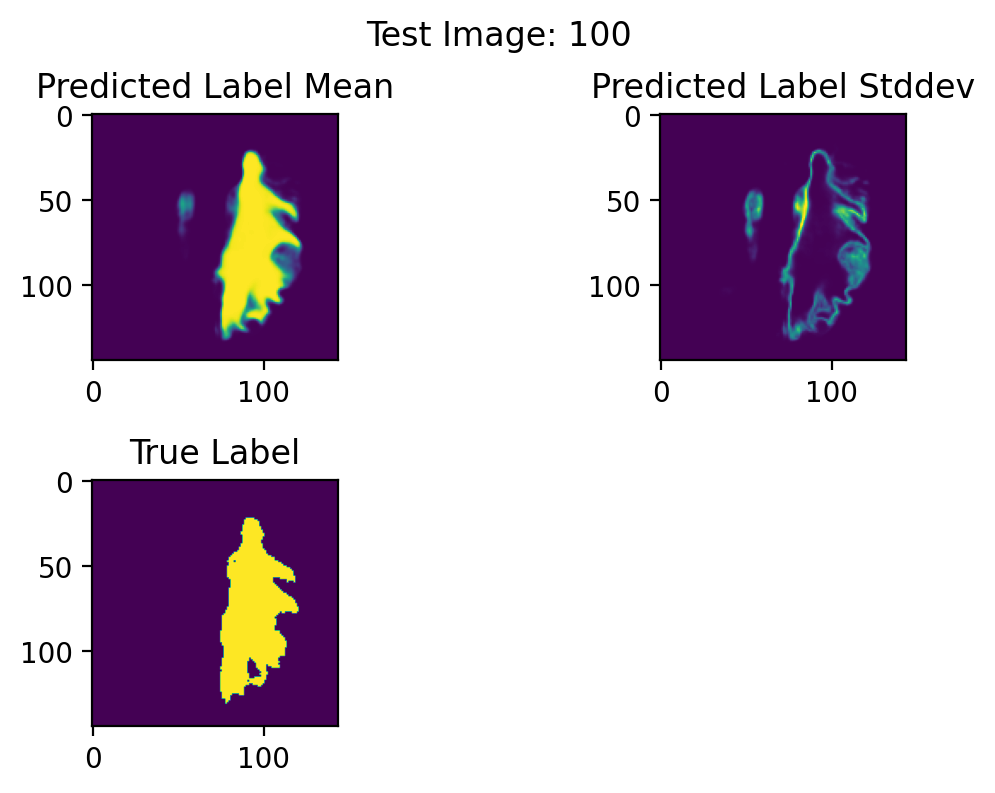

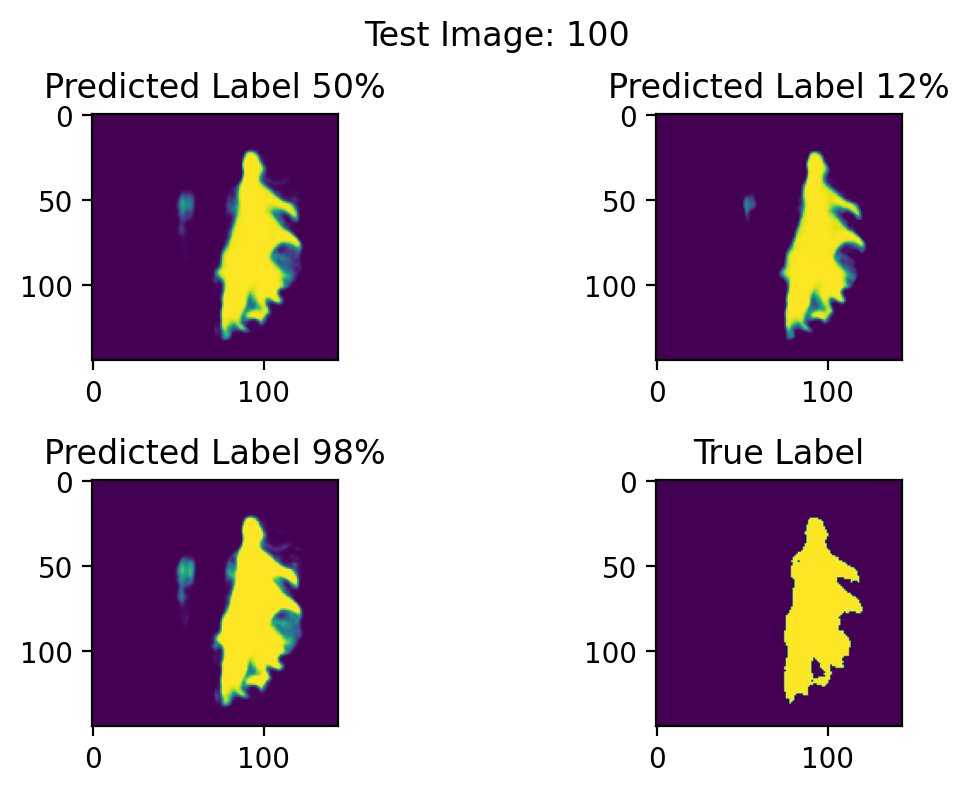

In [70]:
for i in trange(100, 101):
    plt.figure(dpi=200)
    plt.subplot(221)
    plt.title('Test Data 1')
    plt.imshow(imgs_test[i, :, :, 0])

    plt.subplot(222)
    plt.title('Test Data 2')
    plt.imshow(imgs_test[i, :, :, 1])

    plt.subplot(223)
    plt.title('Test Data 3')
    plt.imshow(imgs_test[i, :, :, 2])

    plt.subplot(224)
    plt.title('Test Data 4')
    plt.imshow(imgs_test[i, :, :, 3])
    plt.tight_layout()
    plt.savefig('../images/layer_1/input_images_'+str(i).zfill(4)+'.png')
    plt.close()


    plt.figure(dpi=200)

    plt.subplot(221)
    plt.title('\nPredicted Label Mean')
    plt.imshow(prediction_test.mean(0)[i, :, :, 0])
    plt.clim(0, 1)

    plt.subplot(222)
    plt.title('\nPredicted Label Stddev')
    plt.imshow(prediction_test.std(0)[i, :, :, 0])
    plt.clim(0, 0.2)

    plt.subplot(223)
    plt.title('True Label')
    plt.imshow(msks_test[i, :, :, 0])
    plt.clim(0, 1)
    plt.suptitle('Test Image: ' + str(i) + '\n')

    plt.tight_layout()

    plt.savefig('../images/layer_1/prediction_images_'+str(i).zfill(4)+'.png')


    plt.figure(dpi=200)

    plt.subplot(221)
    plt.title('\nPredicted Label 50%')
    plt.imshow(prediction_test.mean(0)[i, :, :, 0])
    plt.clim(0, 1)

    plt.subplot(222)
    plt.title('\nPredicted Label 12%')
    plt.imshow(np.clip(prediction_test.mean(0)[i, :, :, 0] - 2*prediction_test.std(0)[i, :, :, 0], 0, 1))
    plt.clim(0, 1)

    plt.subplot(223)
    plt.title('Predicted Label 98%')
    plt.imshow(np.clip(prediction_test.mean(0)[i, :, :, 0] + 2*prediction_test.std(0)[i, :, :, 0], 0, 1))
    plt.clim(0, 1)

    plt.subplot(224)
    plt.title('True Label')
    plt.imshow(msks_test[i, :, :, 0])
    plt.clim(0, 1)

    plt.suptitle('Test Image: ' + str(i) + '\n')

    plt.tight_layout()
    plt.savefig('../images/layer_1/prediction_percentile_images_'+str(i).zfill(4)+'.png')

In [76]:
history = pickle.load(open('../layer_1/Layer_1_hist.pkl', 'rb'))

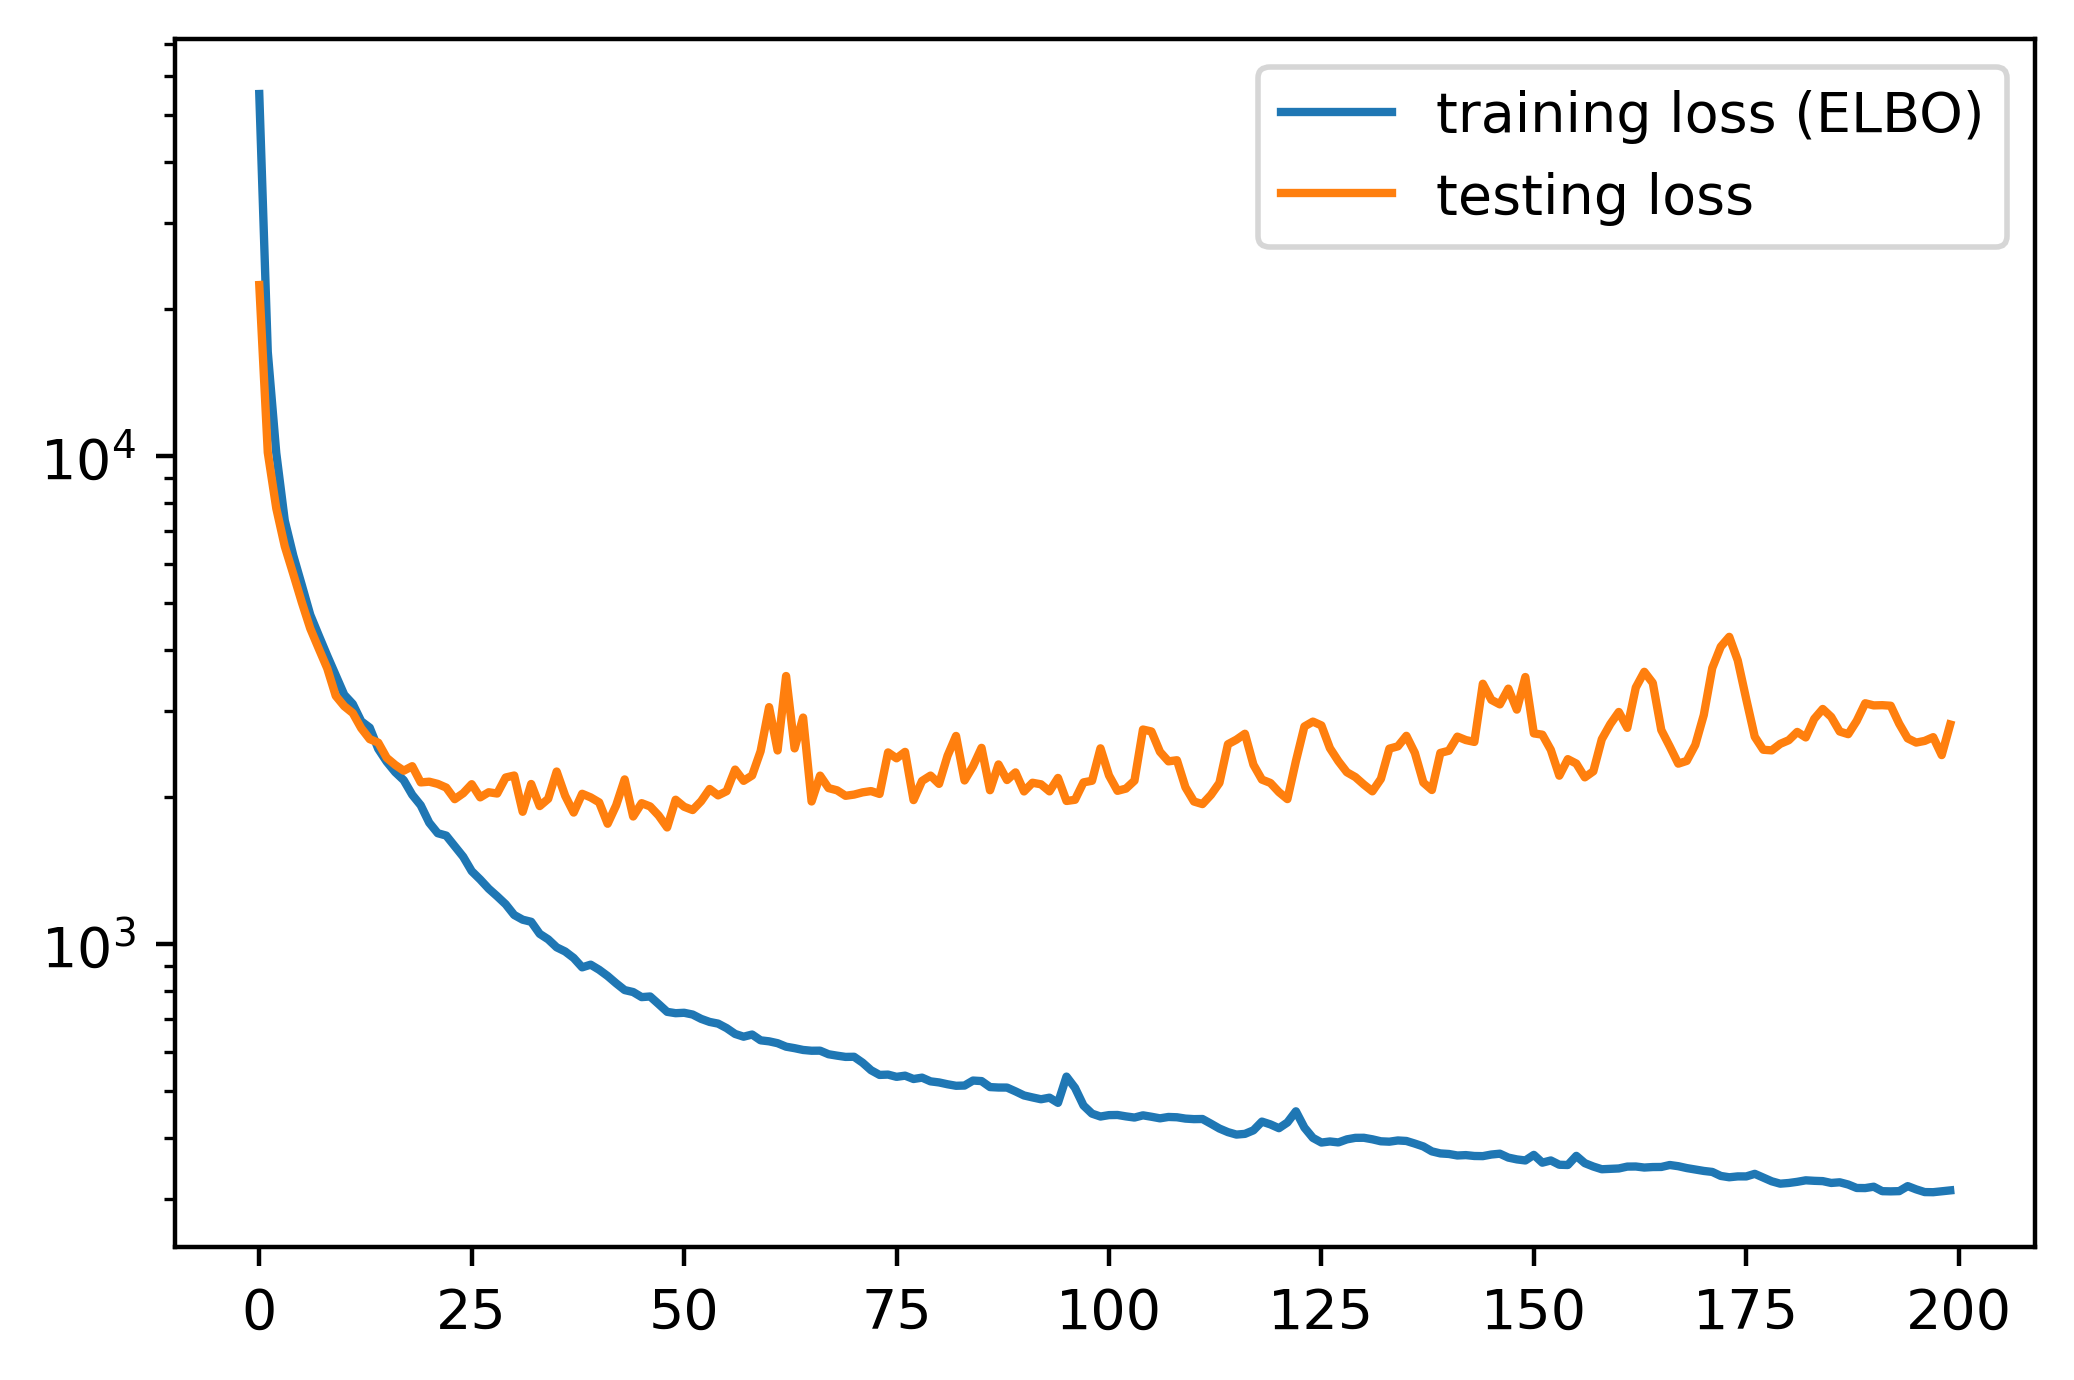

In [88]:
plt.figure(dpi=400)
plt.semilogy(history['loss'], label='training loss (ELBO)')
plt.semilogy(history['val_loss'], label='testing loss')
plt.legend()